In [ ]:
!nvidia-smi

Mon Apr 24 14:20:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

In [ ]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
bs = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part       
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc11 = nn.Linear(10, h_dim1) 
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x, label_one_hot):
        h0 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc11(label_one_hot))
        h2 = torch.add(h0, h1)
        h = F.relu(self.fc2(h2))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        h = F.sigmoid(self.fc6(h)) 
        return h
    
    def forward(self, x, label_one_hot):
        mu, log_var = self.encoder(x.view(-1, 784), label_one_hot)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [ ]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc11): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
vae.fc11.weight.dtype

torch.float32

In [ ]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.float().cuda()
        label_one_hot = F.one_hot(label, 10).float().cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data, label_one_hot)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.float().cuda()
            label_one_hot = F.one_hot(label, 10).float().cuda()
            recon, mu, log_var = vae(data, label_one_hot)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.318848
Train Epoch: 1 [12800/60000 (21%)]	Loss: 189.049973
Train Epoch: 1 [25600/60000 (43%)]	Loss: 171.418076
Train Epoch: 1 [38400/60000 (64%)]	Loss: 168.730438
Train Epoch: 1 [51200/60000 (85%)]	Loss: 162.529083
====> Epoch: 1 Average loss: 184.1362
====> Test set loss: 165.3435
Train Epoch: 2 [0/60000 (0%)]	Loss: 162.696136
Train Epoch: 2 [12800/60000 (21%)]	Loss: 165.829300
Train Epoch: 2 [25600/60000 (43%)]	Loss: 162.957489
Train Epoch: 2 [38400/60000 (64%)]	Loss: 165.339310
Train Epoch: 2 [51200/60000 (85%)]	Loss: 150.096710
====> Epoch: 2 Average loss: 160.8483
====> Test set loss: 157.3615
Train Epoch: 3 [0/60000 (0%)]	Loss: 159.001328
Train Epoch: 3 [12800/60000 (21%)]	Loss: 156.926727
Train Epoch: 3 [25600/60000 (43%)]	Loss: 160.816589
Train Epoch: 3 [38400/60000 (64%)]	Loss: 161.206711
Train Epoch: 3 [51200/60000 (85%)]	Loss: 152.320450
====> Epoch: 3 Average loss: 154.5326
====> Test set loss: 153.0956
Train Epoch: 4 [0/60000 (0%)]	L

In [ ]:
!mkdir './samples'

mkdir: cannot create directory ‘./samples’: File exists


In [ ]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

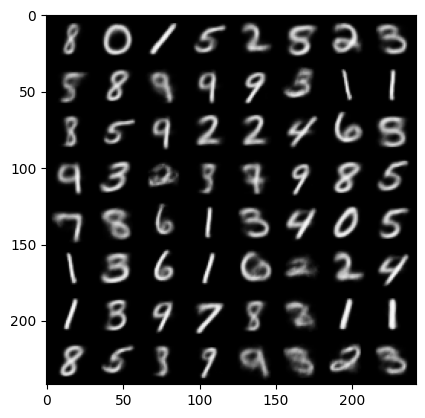

In [ ]:
img = plt.imread('/content/samples/sample_.png')
plt.imshow(img)

In [ ]:
def validate():
    vae.eval()
    with torch.no_grad():
        i = 0
        for data, label in val_loader:
            i += 1
            if i > 0:
                break
        print(label)
        data = data.float().cuda()
        label_one_hot_val = F.one_hot(label, 10).float().cuda()
        recon_val, mu_val, log_var_val = vae(data, label_one_hot_val)
        save_image(data, './samples/data_32' + '.png')
        save_image(recon_val.view(32, 1, 28, 28), './samples/sample_32_correct' + '.png')

        for lab in label:
            if lab == 9:
                lab -= 1
            else:
                lab += 1         
        
        print(label)
        label_one_hot_val_wrong = F.one_hot(label, 10).float().cuda()
        recon_val_wrong, mu_val, log_var_val = vae(data, label_one_hot_val_wrong)  
        save_image(recon_val_wrong.view(32, 1, 28, 28), './samples/sample_32_wrong' + '.png')   

        input_arr   = np.asarray(Image.open('/content/samples/data_32.png'))
        correct_arr = np.asarray(Image.open('/content/samples/sample_32_correct.png'))
        wrong_arr   = np.asarray(Image.open('/content/samples/sample_32_wrong.png'))
        np_arr = np.stack((input_arr, correct_arr, wrong_arr))   

        plt.figure(figsize=(10, 10))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.imshow(np_arr[i])
            plt.axis('off')
        plt.show()        

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
tensor([8, 3, 2, 1, 5, 2, 5, 8, 6, 8, 1, 7, 8, 1, 2, 6, 8, 8, 4, 5, 8, 7, 7, 6,
        5, 1, 8, 5, 1, 2, 4, 2])


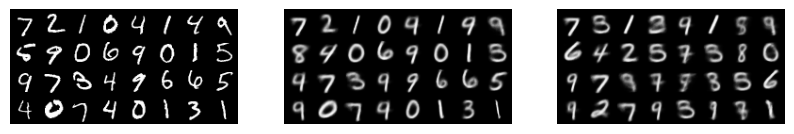

In [ ]:
validate()